In [1]:
#!/usr/bin/env python2
import os
import sys
import argparse
import time
from distutils.dir_util import copy_tree


import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import binary_crossentropy

from iterator import Iterator
import cnn_model as ae_model

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline


_FLOATX = config.floatX


Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/u/larocste/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#Training hyper-parameters

learning_rate = 0.01
weight_decay = 0
num_epochs = 500
max_patience = 100
#data_augmentation={}
SAVEPATH = 'save_models' 
LOADPATH = 'load_models'
batch_size = 512
extract_center = True
load_caption = False
#nb_discriminator_steps = 2

#Model Hyperparameters
conv_before_pool=[2,2,2]
n_filters = 32                      
code_size = 750
filter_size = 3
pool_factor = 2



In [3]:
#######################
# Saving path and stuff
######################
exp_name = 'AE_notebook'
exp_name += '_lr='+str(learning_rate)
exp_name += '_wd='+str(weight_decay)
exp_name += '_bs='+str(batch_size)
exp_name += '_conv='+str(conv_before_pool)
exp_name += '_nfilt='+str(n_filters)
exp_name += '_code='+str(code_size)



savepath=os.path.join(sys.path[1],SAVEPATH, exp_name)
loadpath=os.path.join(sys.path[1],LOADPATH, exp_name)

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))
print 'Saving directory : ' + savepath
print 'Loading directory : '+ loadpath

 The following folder already exists /u/larocste/ift6266_project/save_models/AE_notebook_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=750. It will be overwritten in a few seconds...
Saving directory : /u/larocste/ift6266_project/save_models/AE_notebook_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=750
Loading directory : /u/larocste/ift6266_project/load_models/AE_notebook_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=750


In [4]:
#######################
#Build dataset iterator
#######################

print "Loading training data..." #threads???
train_iter = Iterator(which_set='train', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

print "Loading validation data..." #threads???
valid_iter = Iterator(which_set='valid', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

test_iter = None

n_batches_train = train_iter.n_batches
n_batches_valid = valid_iter.n_batches
n_batches_test = test_iter.n_batches if test_iter is not None else 0

print "Batch. train: %d, val %d, test %d" % (n_batches_train,
                            n_batches_valid, n_batches_test)

Loading training data...
Loading validation data...
Batch. train: 161, val 79, test 0


In [5]:
ae_input_var = T.tensor4('input img bx64x64x3')


model = ae_model.AE_contour2center()
model.build_network(input_var=ae_input_var,
                  conv_before_pool=conv_before_pool,
                  n_filters = n_filters,
                  code_size = code_size,
                  filter_size = filter_size,
                  pool_factor = pool_factor)

In [6]:
model.compile_theano_functions(learning_rate=learning_rate)

Defining and compiling train functions
Defining and compiling valid functions
Defining and compiling get_imgs function
Done


In [7]:
plot_results_train = True
plot_results_valid = True


num_epochs = 2
n_batches_train = 1
n_batches_valid = 1

In [8]:
# Initialization

err_train = []
err_valid = []

best_err_val = 0
patience = 0

reset_best_results = True

Start training


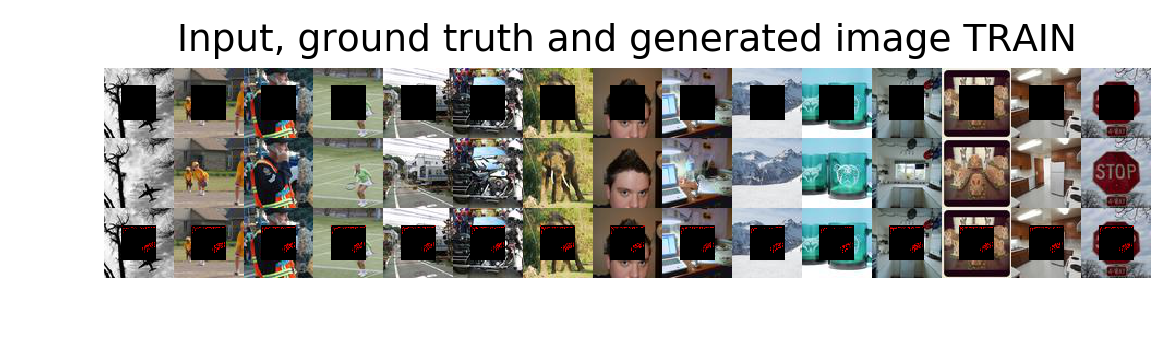

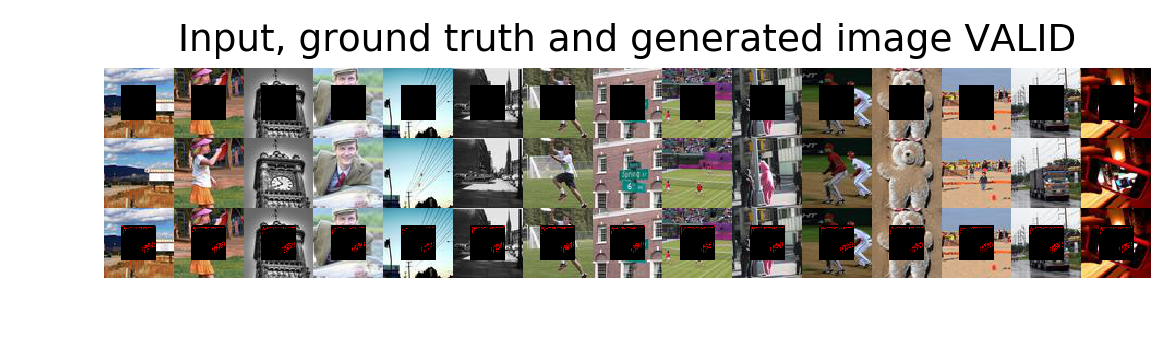

EPOCH 0: Avg cost train 0.937465, cost val 14395712000.000000, took 12.547289 s


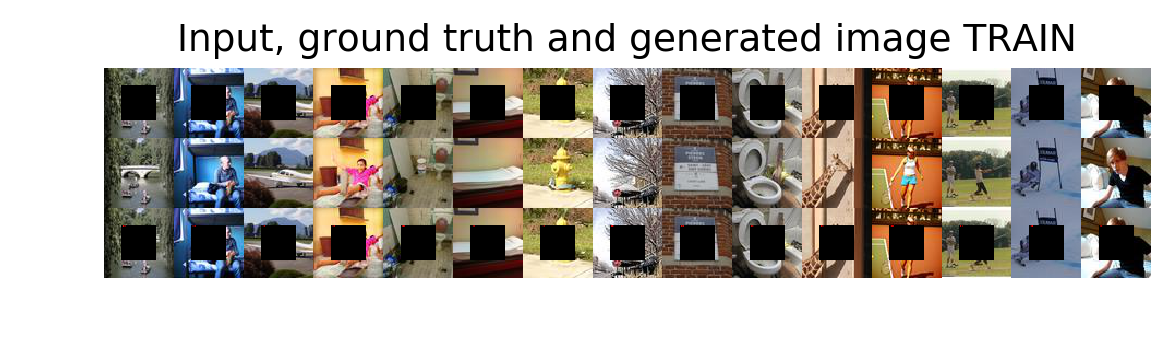

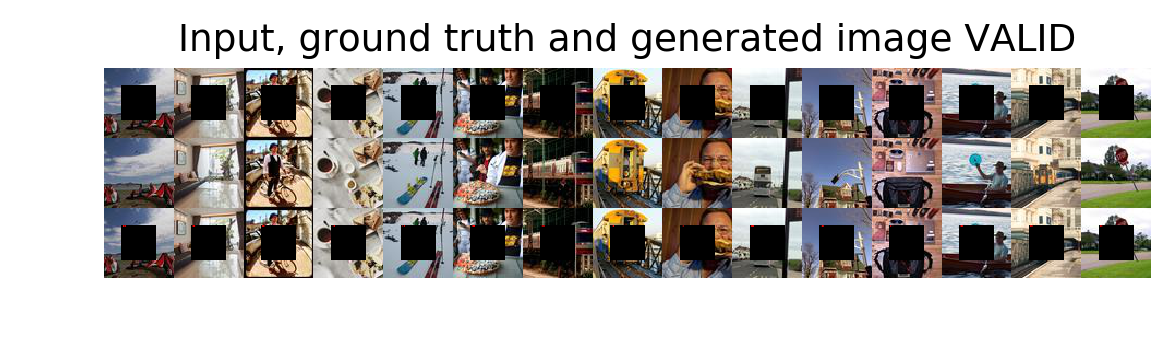

EPOCH 1: Avg cost train 0.519382, cost val 63703214981120.000000, took 7.838766 s
saving last model
Copying model and other training files to /u/larocste/ift6266_project/load_models/AE_notebook_lr=0.01_wd=0_bs=512_conv=[2, 2, 2]_nfilt=32_code=750


In [10]:
#
# Train loop
#



# Training main loop
print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))
    
    start_time = time.time()
    cost_train_epoch = 0
    
    # Train      
        
    for i, train_batch in enumerate(train_iter):
        if n_batches_train > 0 and i> n_batches_train:
            break
        
        train_batch = model.extract_batch(train_batch) 
        inputs_train, targets_train, caps_train = train_batch
        
        
        cost_train_batch =  model.train_fn(inputs_train, targets_train)
        
        #print i, 'training batch cost : ', cost_train_batch

        #Update epoch results    
        cost_train_epoch += cost_train_batch
        
    if plot_results_train: #select random example from the last minibatch and plot it
        model.compute_and_plot_results(train_batch, title = 'TRAIN')
           
        
    #Add epoch results    
    err_train += [cost_train_epoch/n_batches_train]
    
    

    # Validation
    cost_val_epoch = 0
    

    for i, valid_batch in enumerate(valid_iter):
        
        if n_batches_valid > 0 and i> n_batches_valid:
            break

        valid_batch = model.extract_batch(valid_batch)
        inputs_valid, targets_valid, caps_valid = valid_batch

        # Validation step
        cost_val_batch = model.valid_fn(inputs_valid, targets_valid)
        #print i, 'validation batch cost : ', cost_val_batch


        #Update epoch results
        cost_val_epoch += cost_val_batch
        
    if plot_results_valid: #select random example from the last minibatch and plot it
        model.compute_and_plot_results(valid_batch, title = 'VALID')
        
    #Add epoch results 
    err_valid += [cost_val_epoch/n_batches_valid]
    

    #Print results (once per epoch)
    out_str = "EPOCH %i: Avg cost train %f, cost val %f, took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         err_valid[epoch],
                         time.time()-start_time)
    print out_str
   
    

    # Early stopping and saving stuff
    
    with open(os.path.join(savepath, "ae_output.log"), "a") as f:
        f.write(out_str + "\n")
        
    if epoch == 0 and reset_best_results:
        best_err_valid = err_valid[epoch]
    elif epoch > 1 and err_valid[epoch] < best_err_valid:
        print('saving best (and last) model')
        best_err_valid = err_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'ae_model_best.npz'),*lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_best.npz"),err_train=err_train, err_valid=err_valid)
        np.savez(os.path.join(savepath, 'ae_model_last.npz'),*lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"),err_train=err_train, err_valid=err_valid)
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'ae_model_last.npz'), *lasagne.layers.get_all_param_values(model.net))
        np.savez(os.path.join(savepath , "ae_errors_last.npz"), err_train=err_train, err_valid=err_valid)
        
    # Finish training if patience has expired or max nber of epochs reached
    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break 




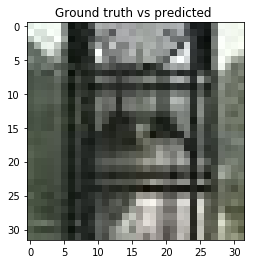

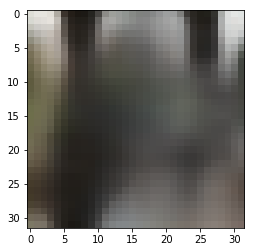

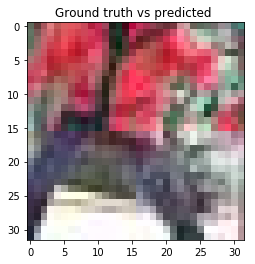

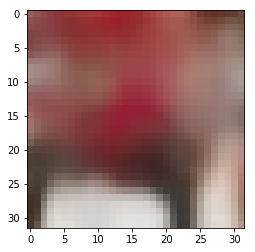

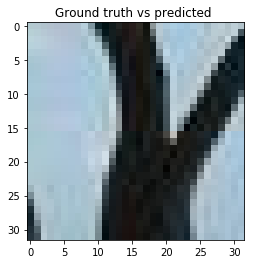

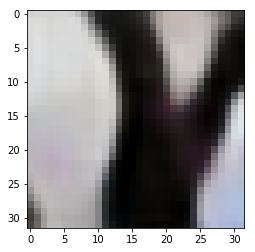

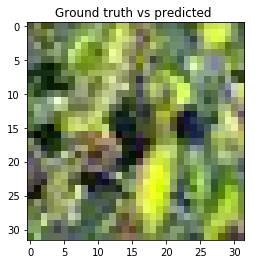

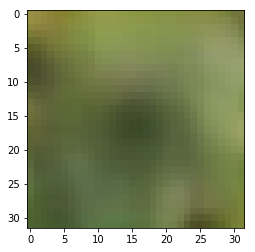

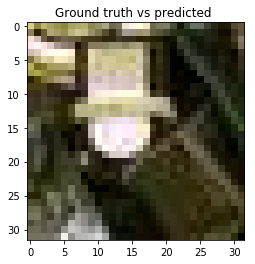

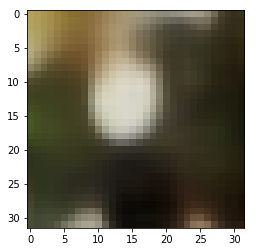

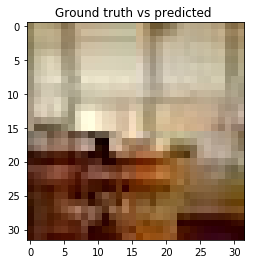

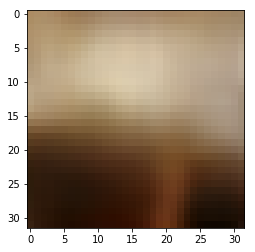

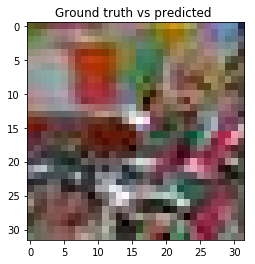

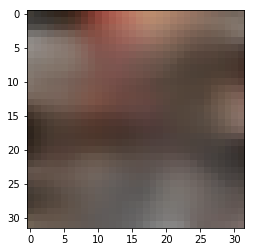

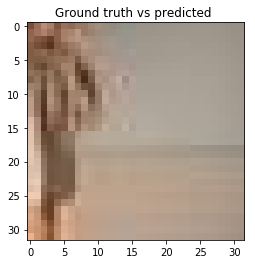

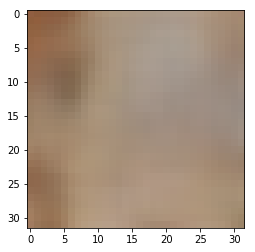

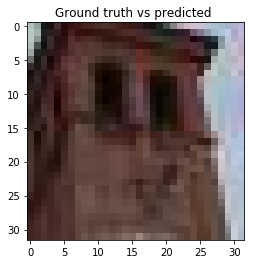

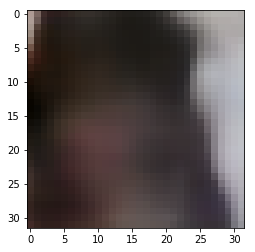

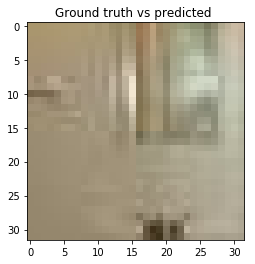

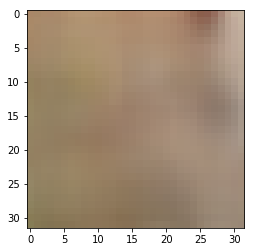

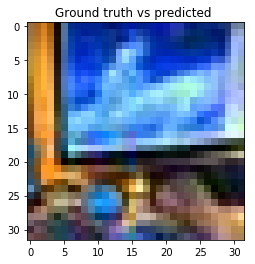

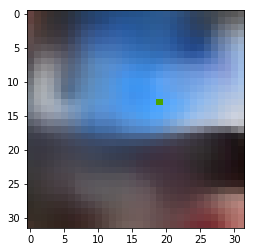

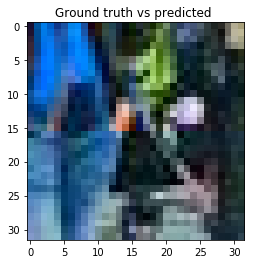

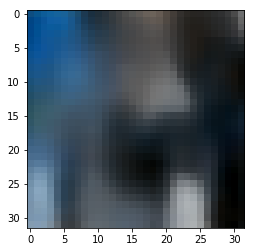

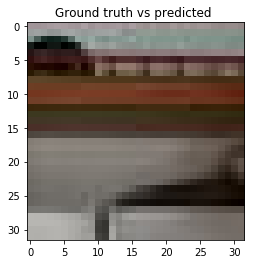

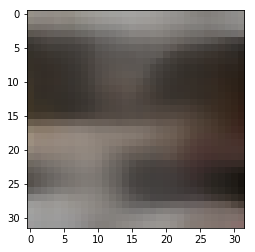

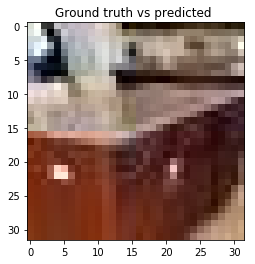

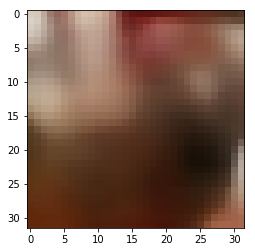

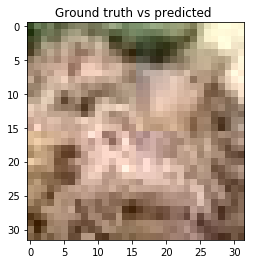

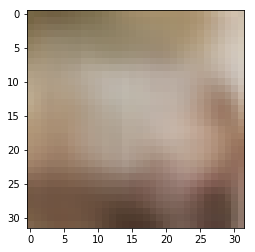

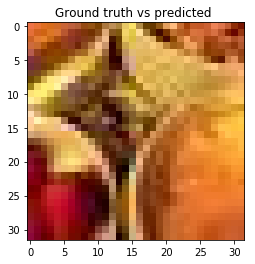

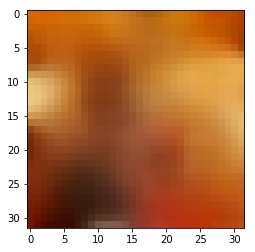

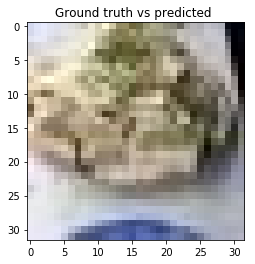

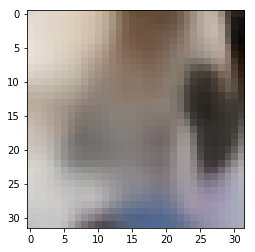

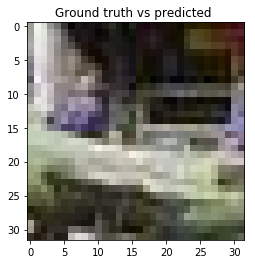

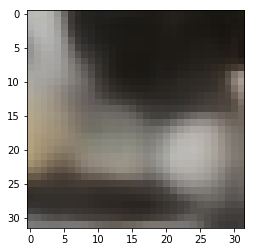

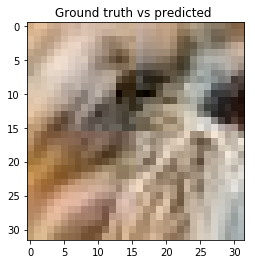

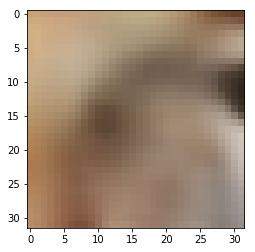

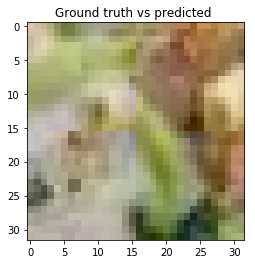

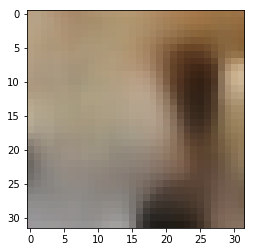

In [127]:
batch_train = extract_stuff(train_iter[400:1000])
        
show_true_fake(batch_train, subset=20)

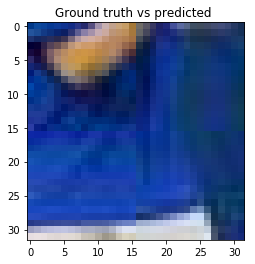

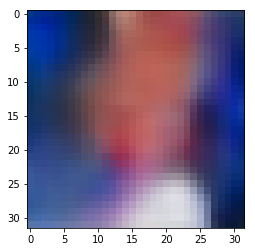

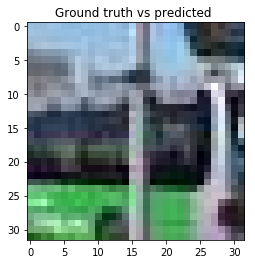

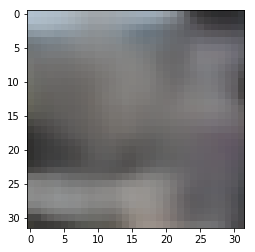

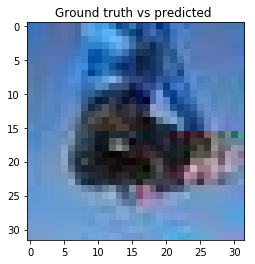

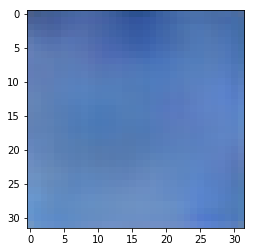

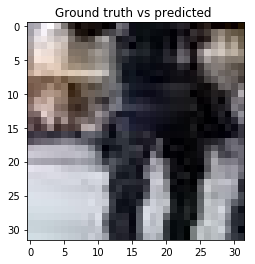

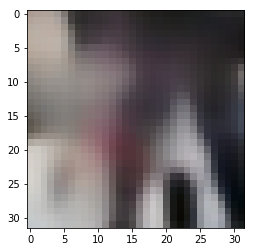

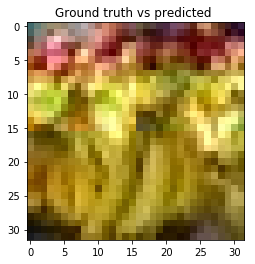

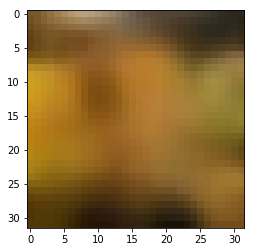

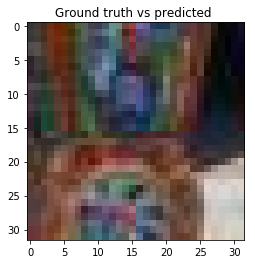

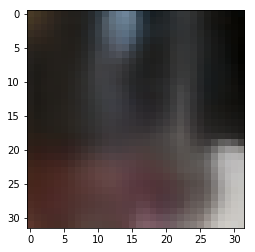

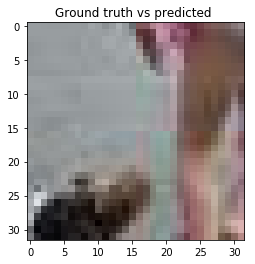

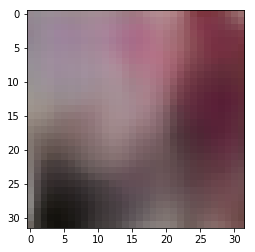

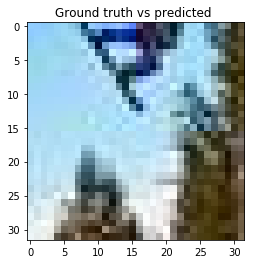

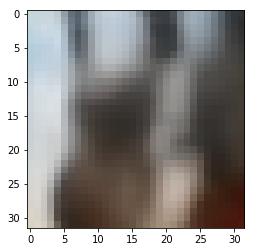

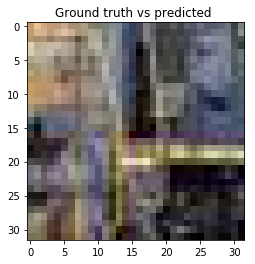

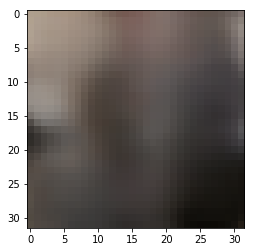

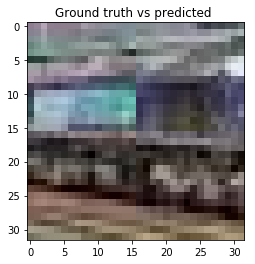

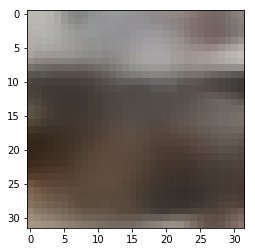

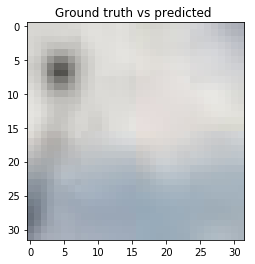

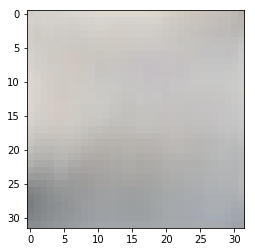

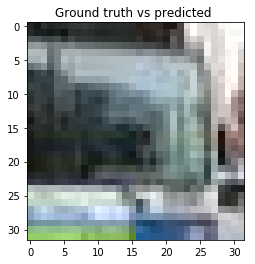

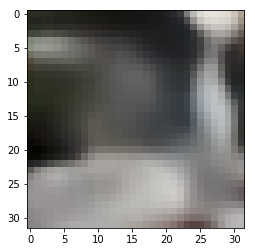

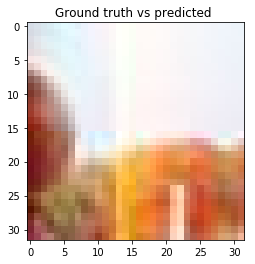

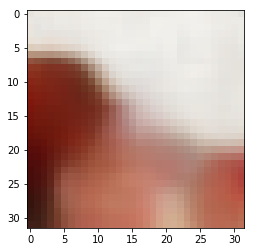

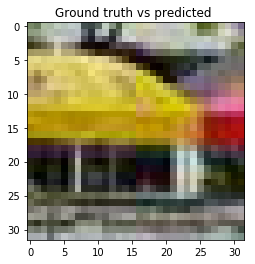

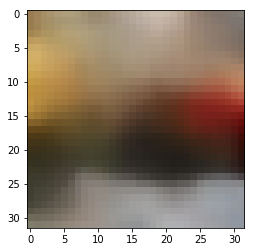

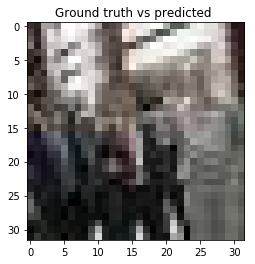

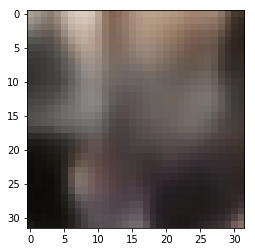

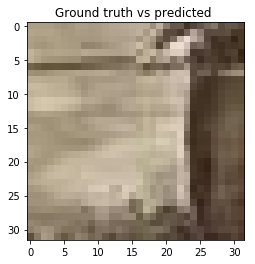

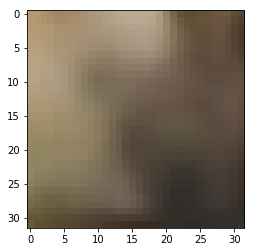

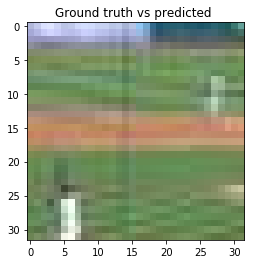

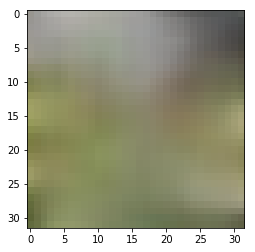

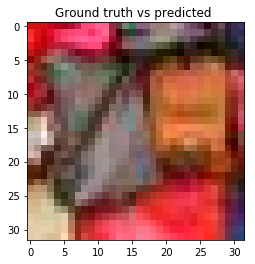

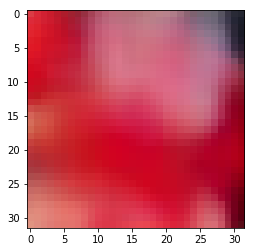

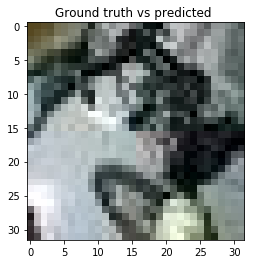

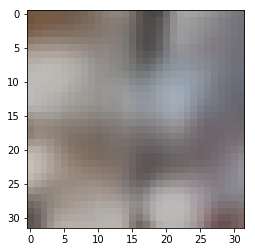

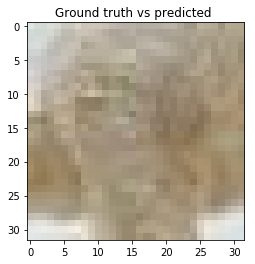

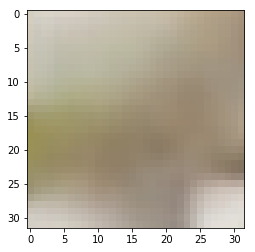

In [130]:
batch_valid = extract_stuff(valid_iter[1500:2000])

show_true_fake(batch_valid, subset = 20)